In [1]:
%matplotlib inline

import pandas
import pickle
import matplotlib.pyplot as plt
import numpy as np
from patsy import *
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import scipy, scipy.stats
from math import *
import seaborn as sns


#What are the most contributing factors\* 
#in predicting success in 
#Animated movies?


In [2]:
# Pickling functions
def pickle_it(data, filename):
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile)

def load_pickle(filename):
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

In [3]:
d = load_pickle('fixyear.pkl')
len(d)

4151

**Scraped 4151 movies**

In [4]:
df = pandas.DataFrame(d)

In [5]:
df = pandas.DataFrame(d)
#print df.dtypes
print df.count()

Budget          767
Gross           424
Metascore       258
OpeningWkd      323
ReleaseDate    3189
Runtime        2742
Title          4151
Year           3838
dtype: int64



Budget          767
Gross           424
Metascore       258
OpeningWkd      323
ReleaseDate    3189
Runtime        2742
Title          4151
Year           3838

**.count() shows all the non NaN or NaT values for each column. if I'm to use all features 258 is max possible rows of data. Of course Metascore is not the only column so..**

In [6]:
cleandf = df[df['Year'] <= 2015].dropna().copy()
cleandf.sort('Year')
#1994 to 2015

,Budget,Gross,Metascore,OpeningWkd,ReleaseDate,Runtime,Title,Year
2678,45000000,422783777,83,16650343,1994-06-24,89,The Lion King,1994
1064,55000000,141600000,58,9423433,1995-06-23,81,Pocahontas,1995
999,30000000,186000,92,18210323,1995-11-22,81,Toy Story,1995
4109,12000000,63071133,64,20114233,1996-12-20,81,Beavis and Butt-Head Do America,1996
2643,2400000000,2298191,76,144446,1997-07-12,134,Princess Mononoke,1997
2390,53000000,5321922,59,120541,1997-11-21,94,Anastasia,1997
605,70000000,101217900,64,725559,1998-12-18,99,The Prince of Egypt,1998
664,120000000,34351136,77,291121,1998-11-25,95,A Bug's Life,1998
597,60000000,90646554,72,17195160,1998-10-02,83,Antz,1998
512,300000000,641760,35,31036678,1998-07-18,96,Pokémon: The First Movie - Mewtwo Strikes Back,1998


**..I end up with 183 movies**

In [7]:
#Split Data 
train, test = train_test_split(cleandf, test_size = 0.2, random_state = 1234)

**What does my data look like?**

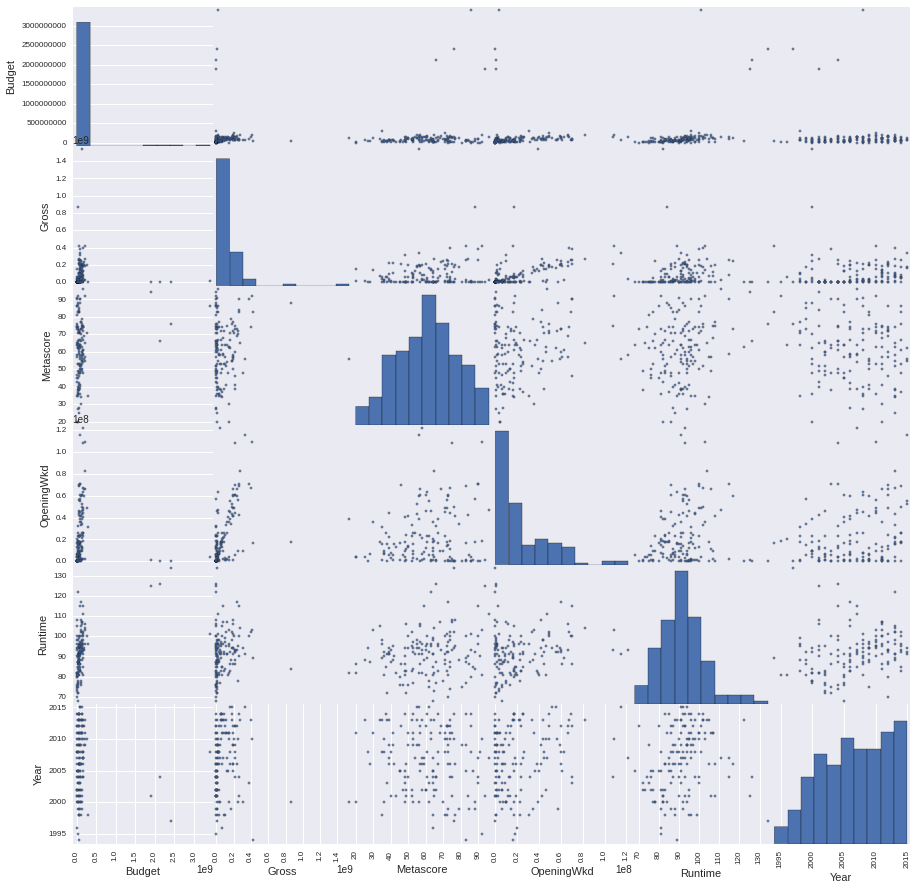

In [8]:
pandas.tools.plotting.scatter_matrix(train , alpha=0.79, figsize=(15,15), grid=True, diagonal='hist')
plt.savefig(r"clean_scattermatrix.png")

**Budget, Gross, OpeningWkd are very right skewed. Normalize with log!**

In [9]:
logtrain = train.copy()
logtrain['Budget'] = logtrain['Budget'].apply(lambda x: np.log(x))
logtrain['Gross'] = logtrain['Gross'].apply(lambda x: np.log(x))
logtrain['OpeningWkd'] = logtrain['OpeningWkd'].apply(lambda x: np.log(x))

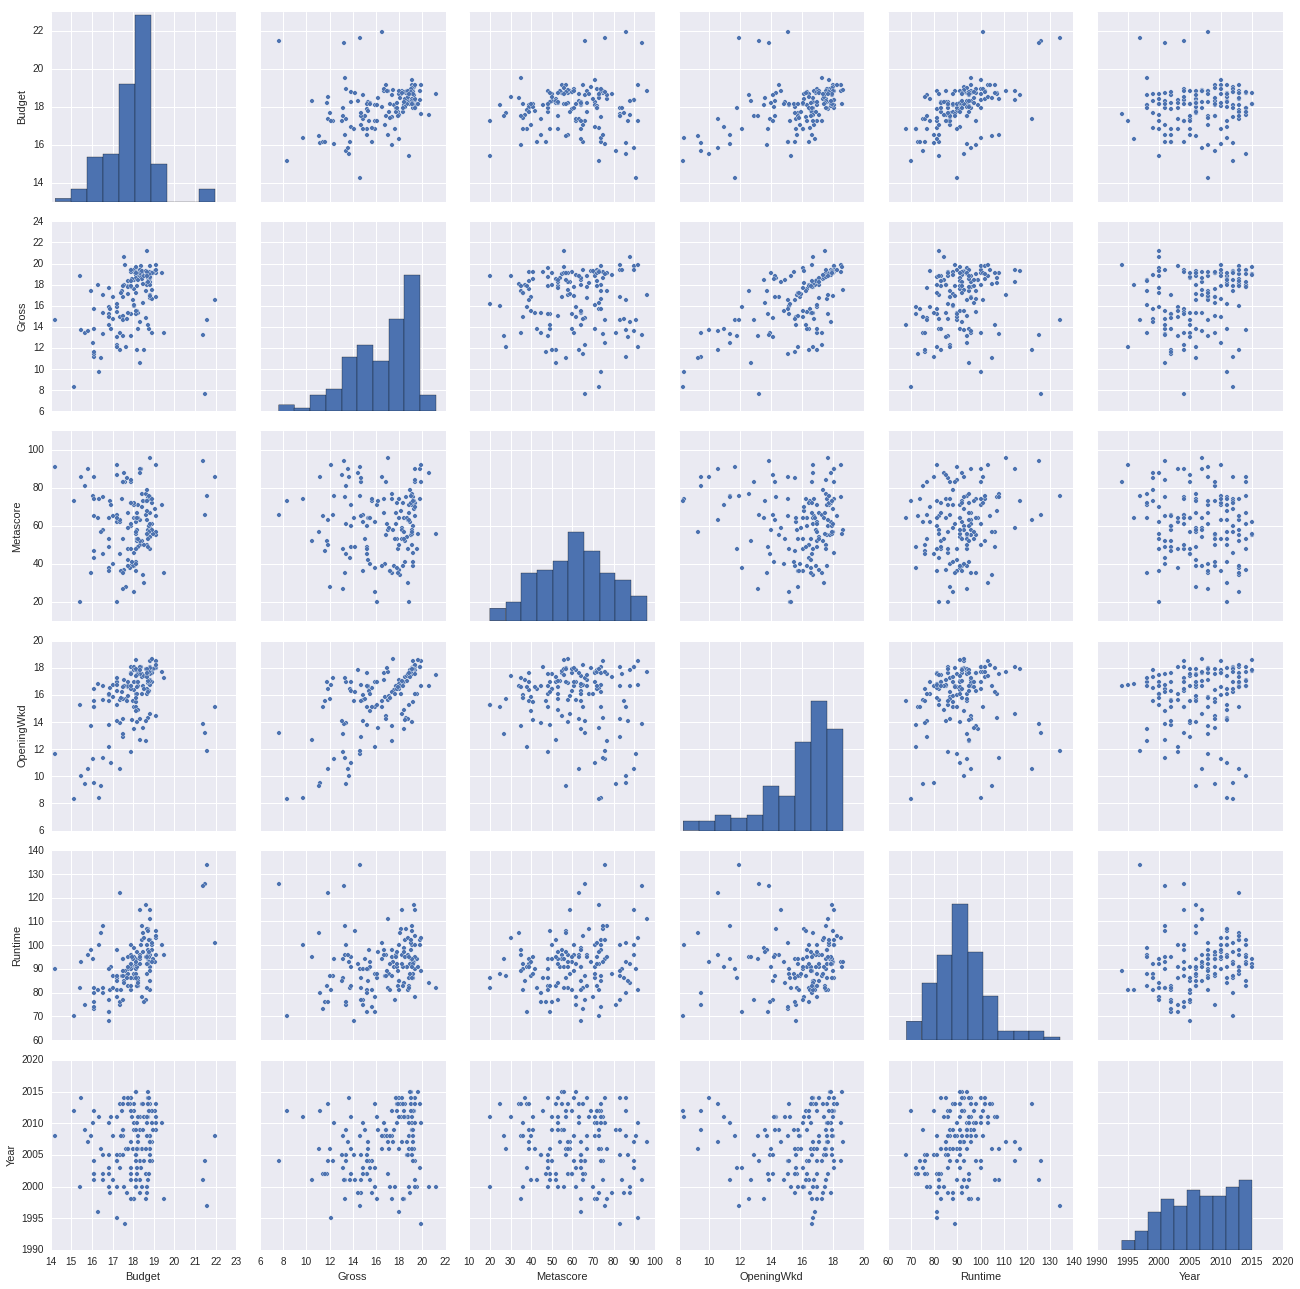

In [10]:
log = sns.PairGrid(logtrain, size = 3, aspect = 1)
log = log.map_offdiag(plt.scatter, edgecolor = 'w')
log = log.map_diag(plt.hist)

**Histograms are more gaussian than before**

In [11]:
noRelease = logtrain[['Budget', 'OpeningWkd', 'Metascore', 'Runtime', 'Year','Gross']].copy()

**Now the data is visible, check the important variable**

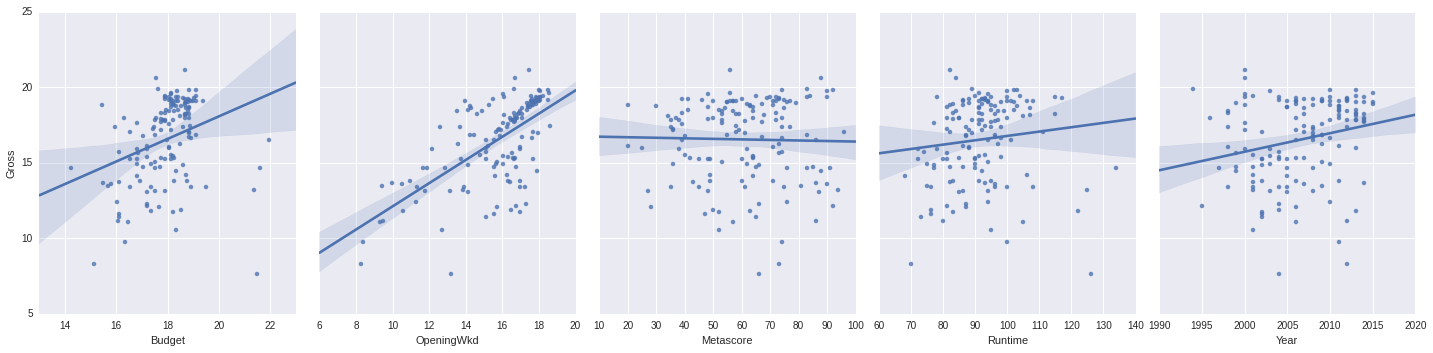

In [12]:
fit=sns.pairplot(logtrain, x_vars = ['Budget', 'OpeningWkd', 'Metascore', 'Runtime', 'Year'], y_vars = ['Gross'], 
             size = 5, aspect =.8, kind = 'reg')

**Fitting a line gives a general feel of how good the correlation is/can be.  **

In [13]:
#import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            print formula
            score = smf.ols(formula, data).fit().rsquared_adj 
            print score
            print
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


In [14]:
model = forward_selected(logtrain[['Budget', 'OpeningWkd', 'Metascore', 'Runtime', 'Year','Gross']], 'Gross')

Gross ~ OpeningWkd + 1
0.409029253249

Gross ~ Budget + 1
0.0911970074549

Gross ~ Metascore + 1
-0.00644011890652

Gross ~ Year + 1
0.0455178314419

Gross ~ Runtime + 1
0.0068885398221

Gross ~ OpeningWkd + Budget + 1
0.40628074248

Gross ~ OpeningWkd + Metascore + 1
0.40679239734

Gross ~ OpeningWkd + Year + 1
0.446249952004

Gross ~ OpeningWkd + Runtime + 1
0.417272982686

Gross ~ OpeningWkd + Year + Budget + 1
0.44334793852

Gross ~ OpeningWkd + Year + Metascore + 1
0.447781037309

Gross ~ OpeningWkd + Year + Runtime + 1
0.447553052664

Gross ~ OpeningWkd + Year + Metascore + Budget + 1
0.444318279451

Gross ~ OpeningWkd + Year + Metascore + Runtime + 1
0.447095138293



In [15]:
print model.model.formula
print model.rsquared_adj
model.summary()

Gross ~ OpeningWkd + Year + Metascore + 1
0.447781037309


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Gross   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     40.19
Date:                Fri, 09 Oct 2015   Prob (F-statistic):           7.25e-19
Time:                        12:11:42   Log-Likelihood:                -308.71
No. Observations:                 146   AIC:                             625.4
Df Residuals:                     142   BIC:                             637.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -225.5940     67.361     -3.349      0.001      -358.754   -92.435
OpeningWkd     0.7669      0.074     10.337      0.000         0.620     0.914
Year           0.1143      0.034      3.408      0.001         0.048     0.181
Metascore      0.0119      0.010      1.182      0.239        -0.008     0.032
==============================================================================
Omnibus:                        8.013   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.170
Skew:                          -0.452   Prob(JB):                       0.0168
Kurtosis:                       3.725   Cond. No.                     8.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Gross ~ OpeningWkd + Year + Runtime + 1**  
0.447553052664

**Gross ~ OpeningWkd + Year + Metascore + Budget + 1**  
0.444318279451

**Gross ~ OpeningWkd + Year + Metascore + Runtime + 1**  
0.447095138293


**Confirm normality of residuals**

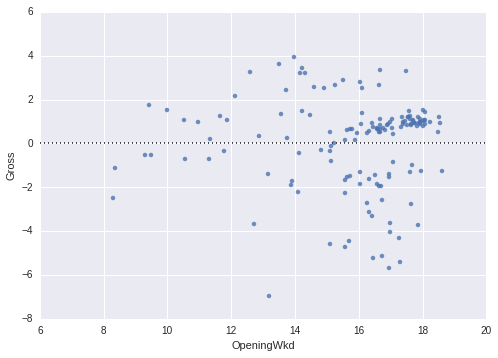

In [16]:
sns.residplot(x = logtrain['OpeningWkd'], y = logtrain['Gross'])

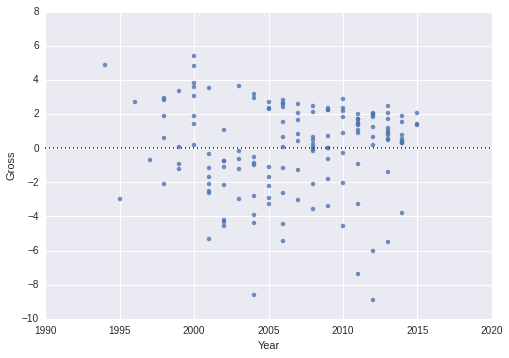

In [17]:
sns.residplot(x = logtrain['Year'], y = logtrain['Gross'])

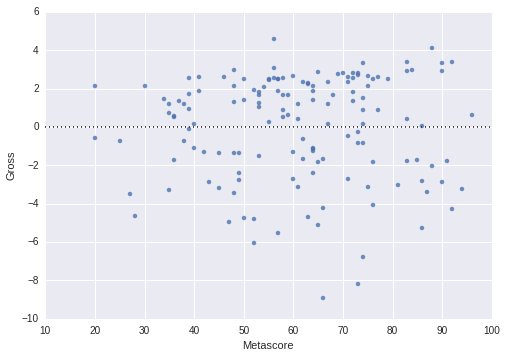

In [18]:
sns.residplot(x = logtrain['Metascore'], y = logtrain['Gross'])

In [19]:
test

,Budget,Gross,Metascore,OpeningWkd,ReleaseDate,Runtime,Title,Year
3485,8000000,7002255,91,572207,2004-02-13,78,The Triplets of Belleville,2003
3081,25000000,14532946,36,1900523,2008-08-29,84,Fly Me to the Moon 3D,2008
4005,100000000,124870275,66,1583544,2009-09-18,90,Cloudy with a Chance of Meatballs,2009
3315,75000000,133103929,24,23244744,2011-12-16,87,Alvin and the Chipmunks: Chipwrecked,2011
3353,80000000,36073232,37,7091938,2013-12-20,87,Walking with Dinosaurs 3D,2013
3270,175000000,34284193,88,68108790,2009-05-29,96,Up,2009
2728,103000000,131536019,49,39327869,2014-04-11,101,Rio 2,2014
3588,75000000,73661010,68,22217226,2006-07-21,91,Monster House,2006
2363,145000000,111505642,59,32207057,2014-03-07,92,Mr. Peabody & Sherman,2014
1046,750000,5518918,54,3005175,2007-04-13,86,Aqua Teen Hunger Force Colon Movie Film for Th...,2007


In [20]:
ytrain = logtrain['Gross']
xtrain = logtrain[['OpeningWkd', 'Year','Metascore']]
ytest = test[['Gross']]
xtest = test[['OpeningWkd', 'Year', 'Metascore']]

In [21]:
est = sm.OLS(ytrain, xtrain).fit()


In [22]:
pred_y = est.predict(xtest)

In [23]:
mean_squared_error(pred_y, ytest)

17136787686462970.0

38       0.258899
87       0.057534
104      2.708822
145      0.305312
166      0.212085
196      0.323404
203      1.000000
213      0.283514
220      0.269539
234      0.005972
251      0.158219
262     11.136000
274     38.943928
333      0.012894
343      0.025306
351      1.984236
354      0.307013
459      0.168169
463      0.229916
477      0.889360
483      0.291181
512     48.361814
526      0.203875
597      0.189695
605      0.007168
608      0.017527
643     99.161822
662      0.013300
664      0.008475
665      0.323420
          ...    
3524     3.533561
3530     2.333832
3551     0.345444
3560     0.255587
3588     0.301614
3628     7.878569
3657     0.025468
3673     3.039220
3699     2.547239
3810     0.184466
3824     0.209359
3826     0.242855
3827     0.164172
3847     0.439184
3881     0.269683
3946     0.291879
3951    23.449079
3973     2.405720
3988     0.251579
4005     0.012682
4024    14.386222
4029     4.049251
4043     0.249706
4045     1.623138
4054     0

In [24]:
ipython nbconvert luther_things.ipynb --to slides --post serve


SyntaxError: invalid syntax (<ipython-input-24-1949f82ac85e>, line 1)